In [7]:
import warnings

warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

import numpy as np
import pandas as pd
import scanpy as sc
sc.settings.verbosity = 0
import SEACells

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

# Peaks data
from scipy.io import mmread

%matplotlib inline
sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

sc.set_figure_params(figsize=(10,10),dpi=120)

# Joint analysis of RNA & ATAC

In [ ]:
filter_intersect = True
rna = sc.read_h5ad('./data/rna-multiome10x-mouse.h5ad')
atac = sc.read_h5ad('./data/atac-multiome10x-mouse.h5ad')

if filter_intersect:
    shared_cells = np.intersect1d(rna.obs.index,atac.obs.index)

    atac = atac[atac.obs.index.isin(shared_cells)]
    rna = rna[rna.obs.index.isin(shared_cells)]

    atac = atac[atac.obs.sort_index().index]
    rna = rna[rna.obs.sort_index().index]

    # Check that the dataframes are in the same order
    if all(atac.obs.index == rna.obs.index):
        print('Success')

In [ ]:
rna.layers["counts"] = rna.raw.X.copy()
atac.layers["counts"] = atac.raw.X.copy()

### Run SEACells on RNA

In [4]:
## Core parameters 
n_SEACells = int(len(rna)/75)
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

model = SEACells.core.SEACells(rna, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

In [5]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/4349 [00:00<?, ?it/s]

Making graph symmetric...
Computing RBF kernel...


  0%|          | 0/4349 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/4349 [00:00<?, ?it/s]

Constructing CSR matrix...


/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


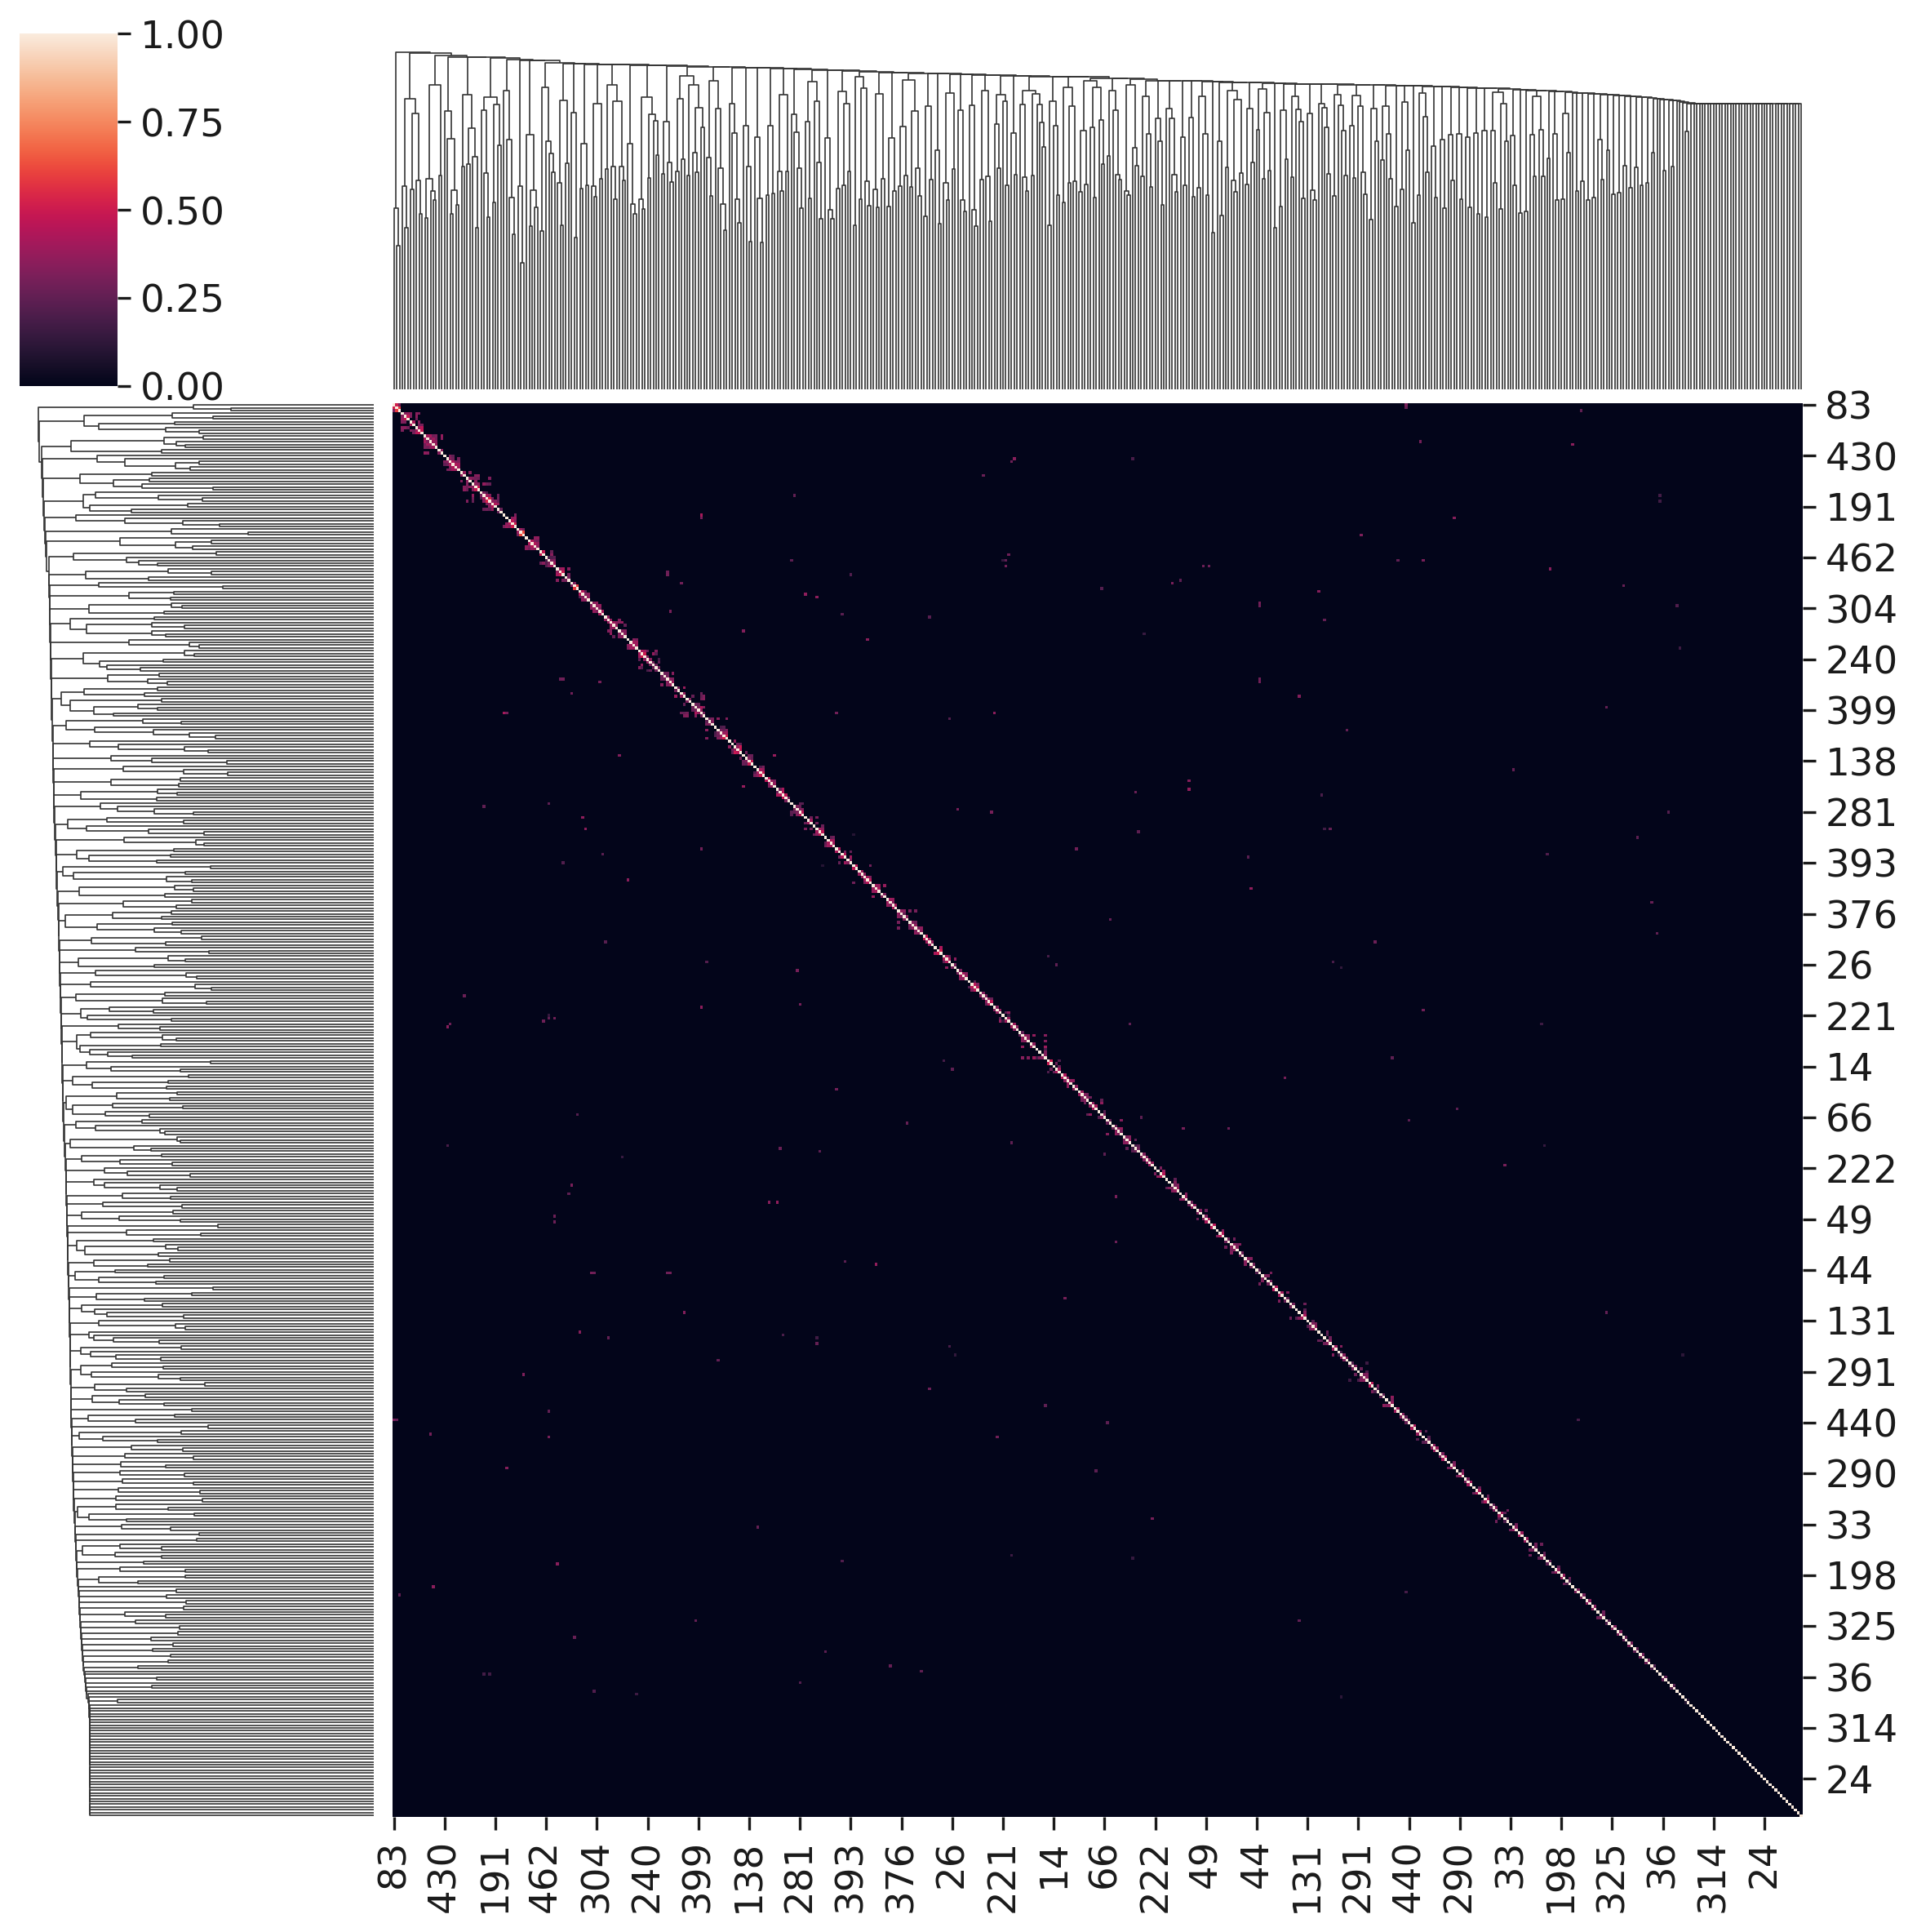

In [8]:
sns.clustermap(M.toarray()[:500,:500])

In [9]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 50 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/17 [00:00<?, ?it/s]

Selecting 7 cells from greedy initialization.


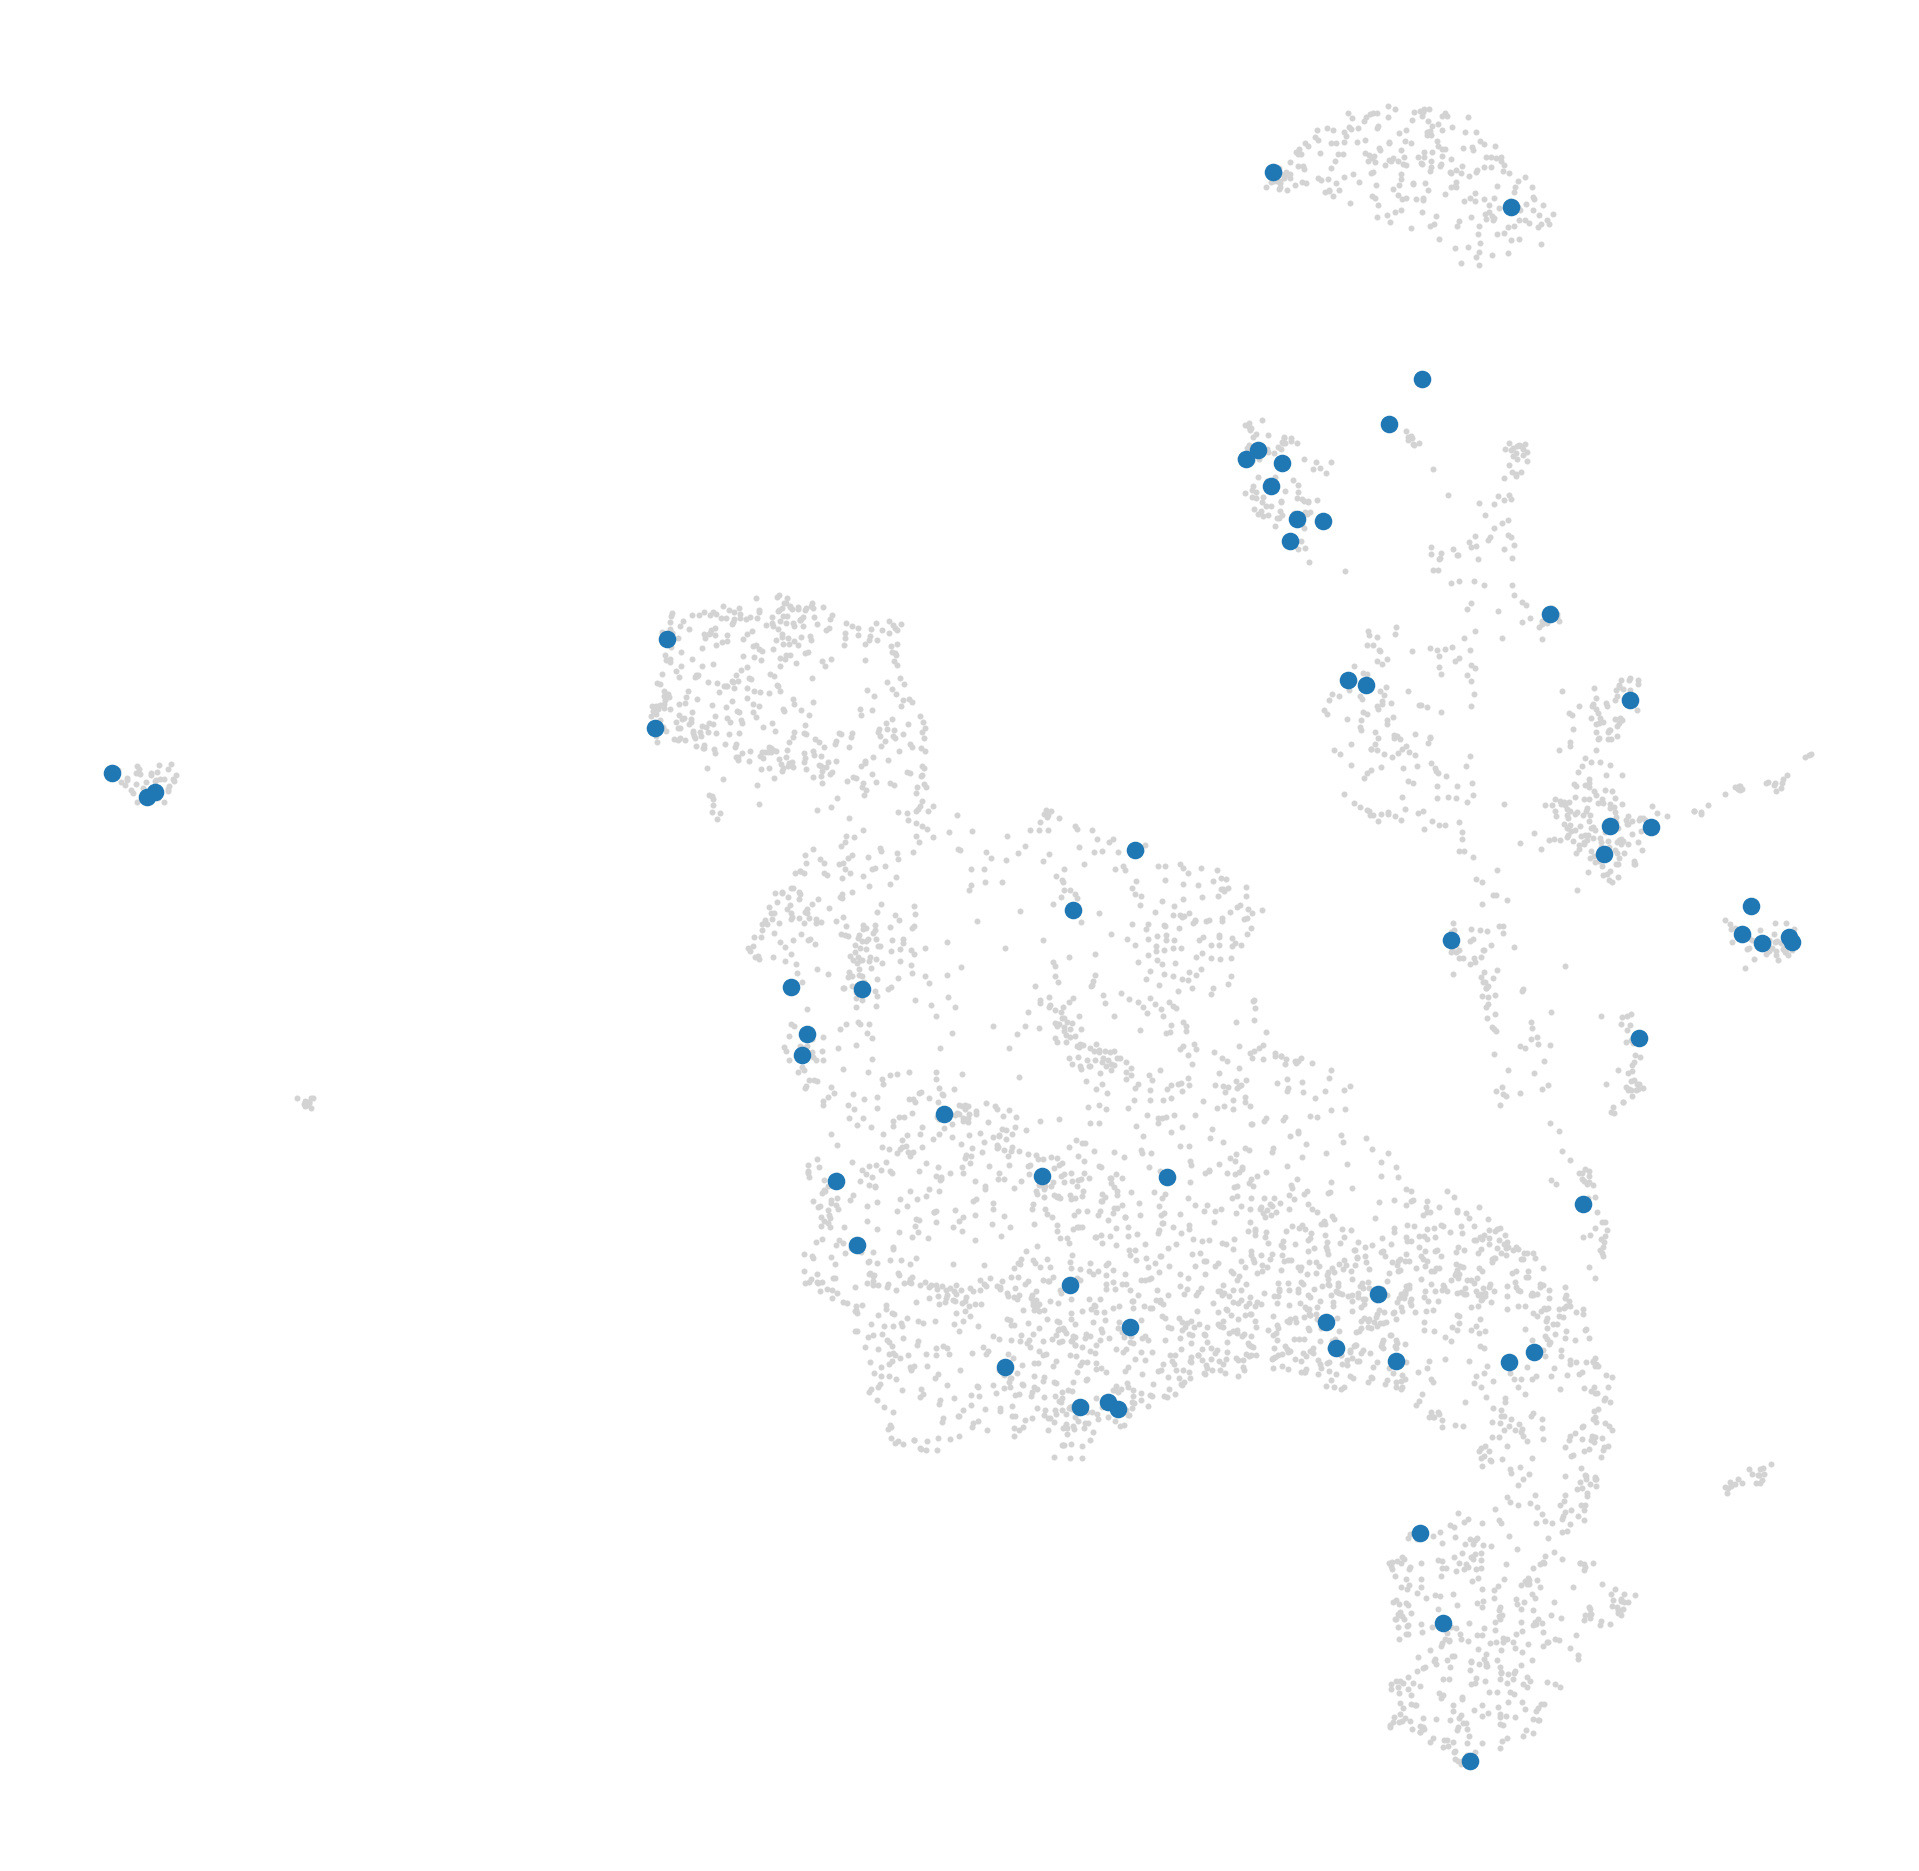

In [10]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(rna, model)

In [11]:
model.fit(min_iter=10, max_iter=50)

# You can force the model to run additional iterations step-wise using the .step() function
print(f'Ran for {len(model.RSS_iters)} iterations')
for _ in range(5):
    model.step()
print(f'Ran for {len(model.RSS_iters)} iterations')

Randomly initialized A matrix.
Setting convergence threshold at 0.00115
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Starting iteration 40.
Completed iteration 40.
Converged after 43 iterations.
Ran for 44 iterations
Ran for 49 iterations


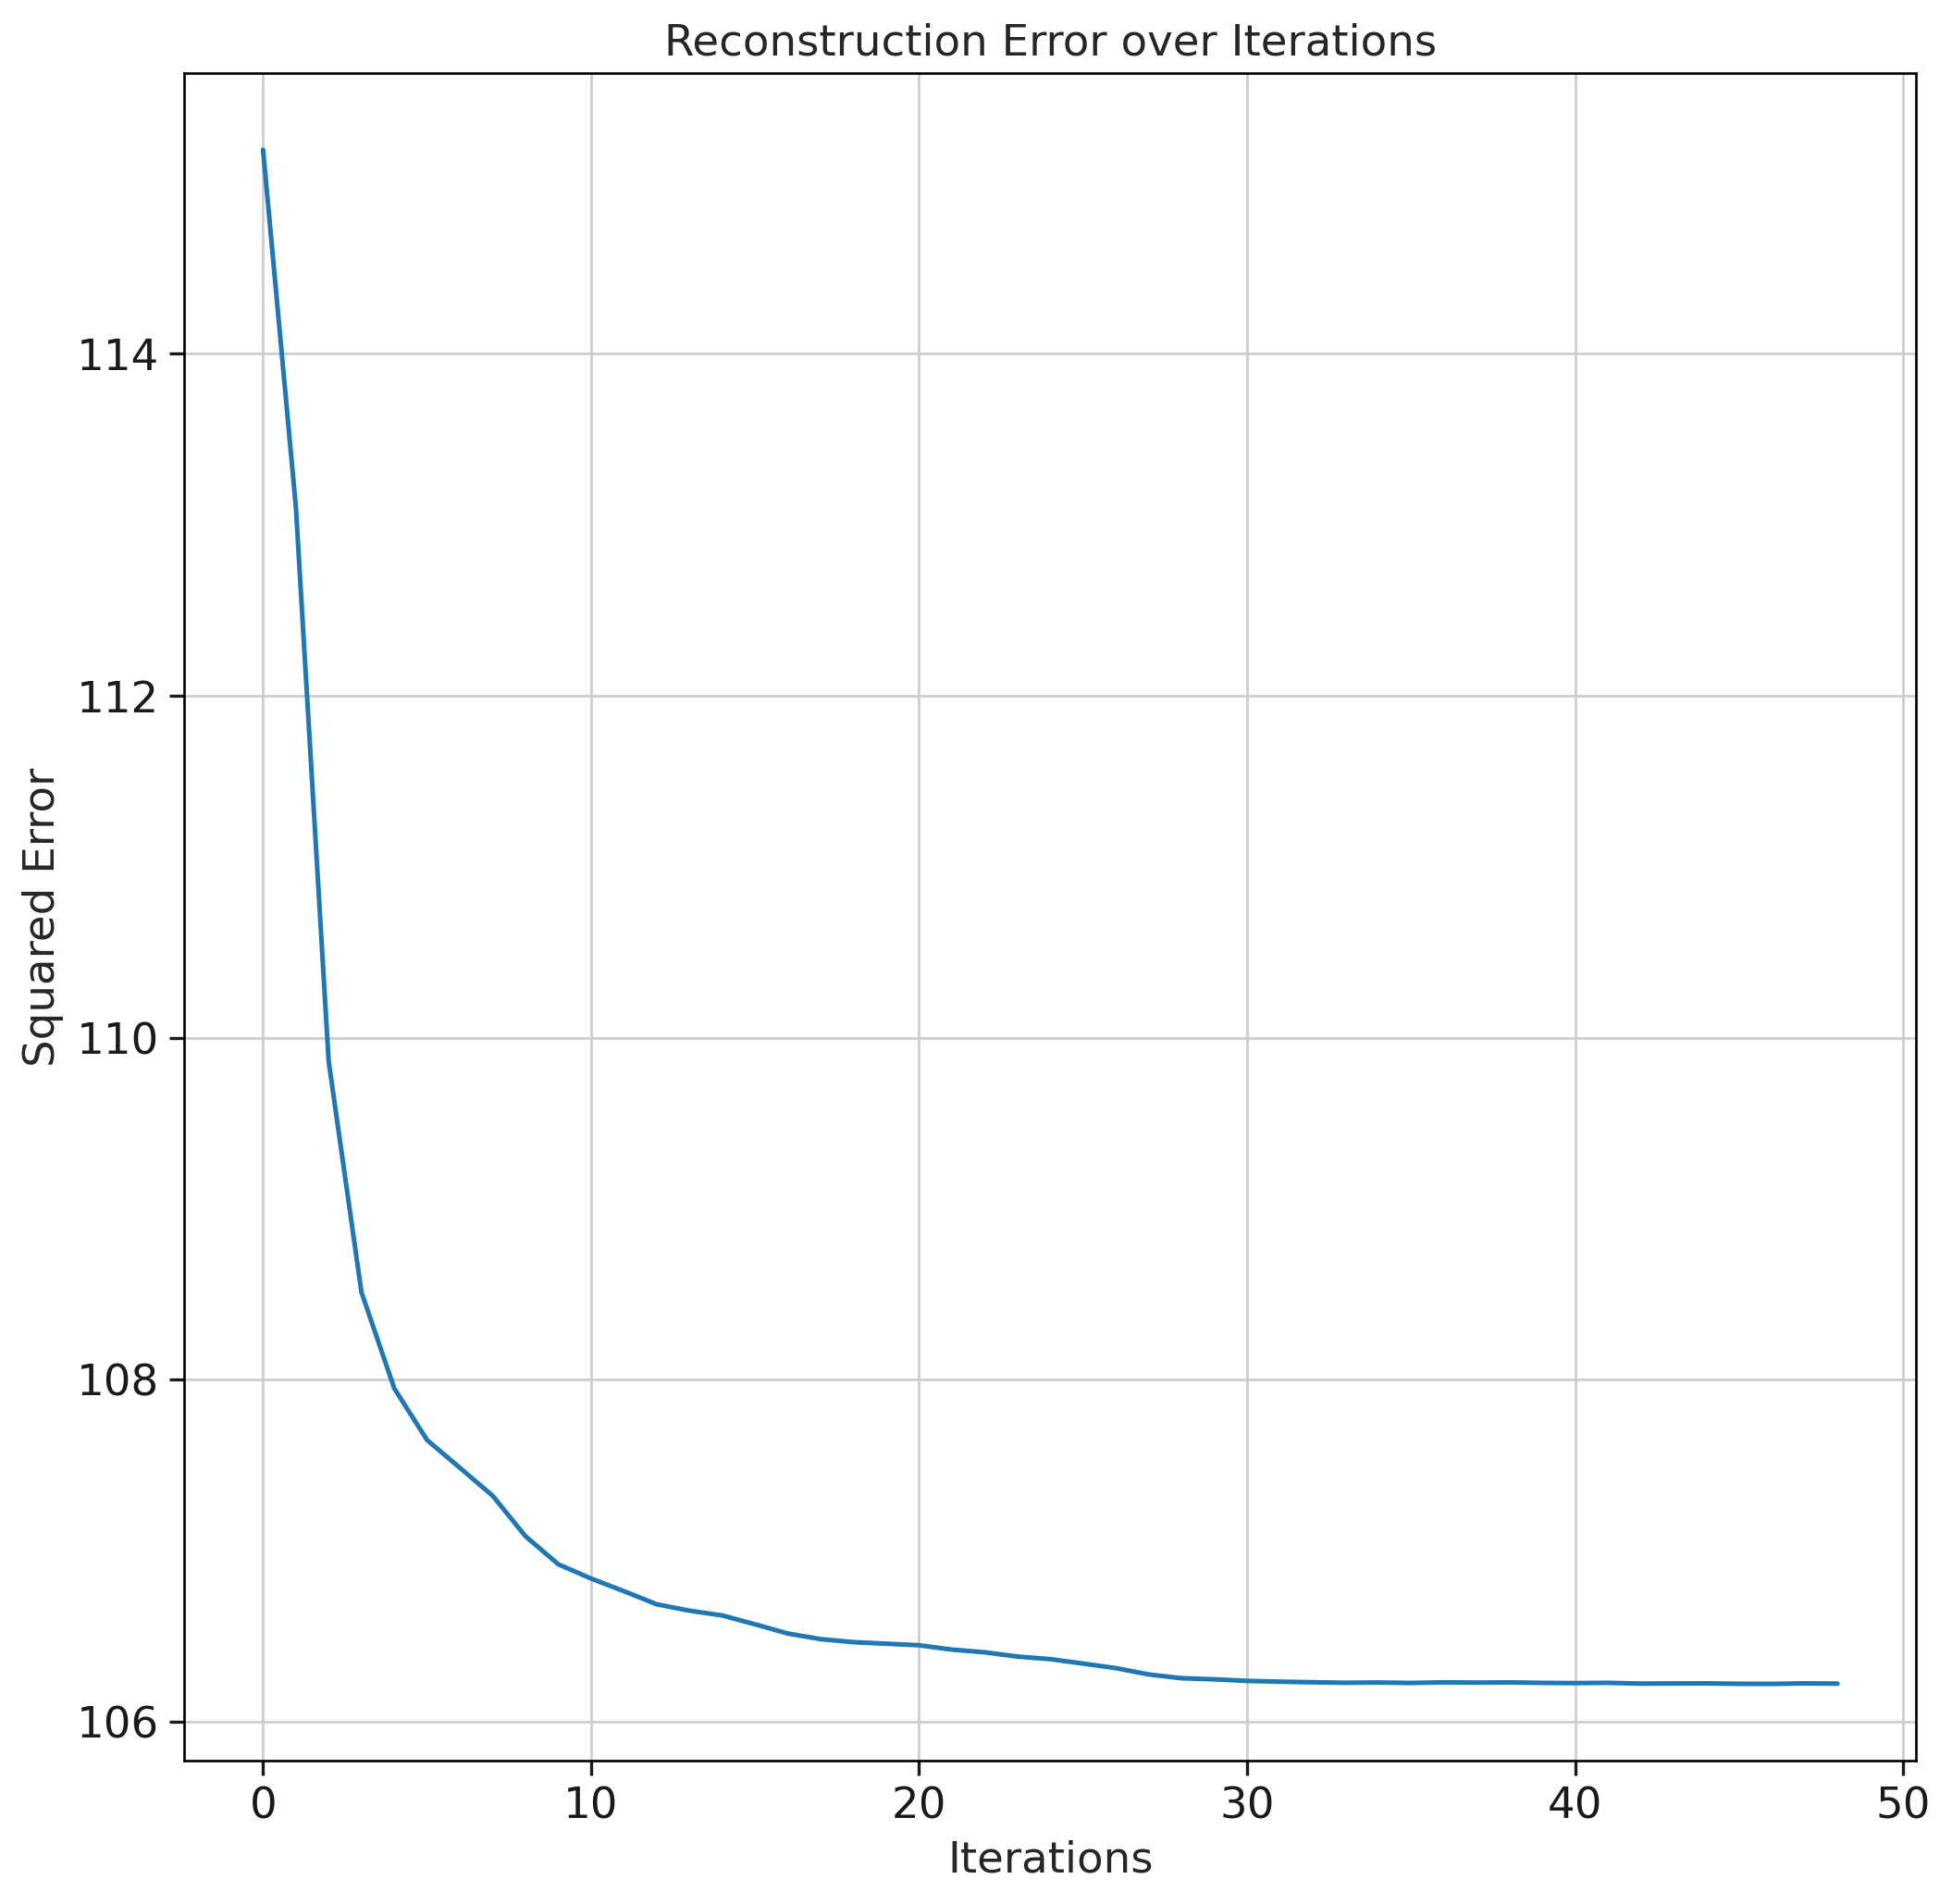

In [12]:
# Check for convergence 
model.plot_convergence()

In [13]:
SEACell_rna = SEACells.core.summarize_by_SEACell(rna, SEACells_label='SEACell', summarize_layer='raw')
SEACell_rna

  0%|          | 0/57 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 57 × 32285
    layers: 'raw'

In [14]:
SEACell_soft_ad = SEACells.core.summarize_by_soft_SEACell(rna, model.A_, celltype_label='leiden',summarize_layer='raw', minimum_weight=0.05)
SEACell_soft_ad

  0%|          | 0/57 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 57 × 32285
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity'

/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


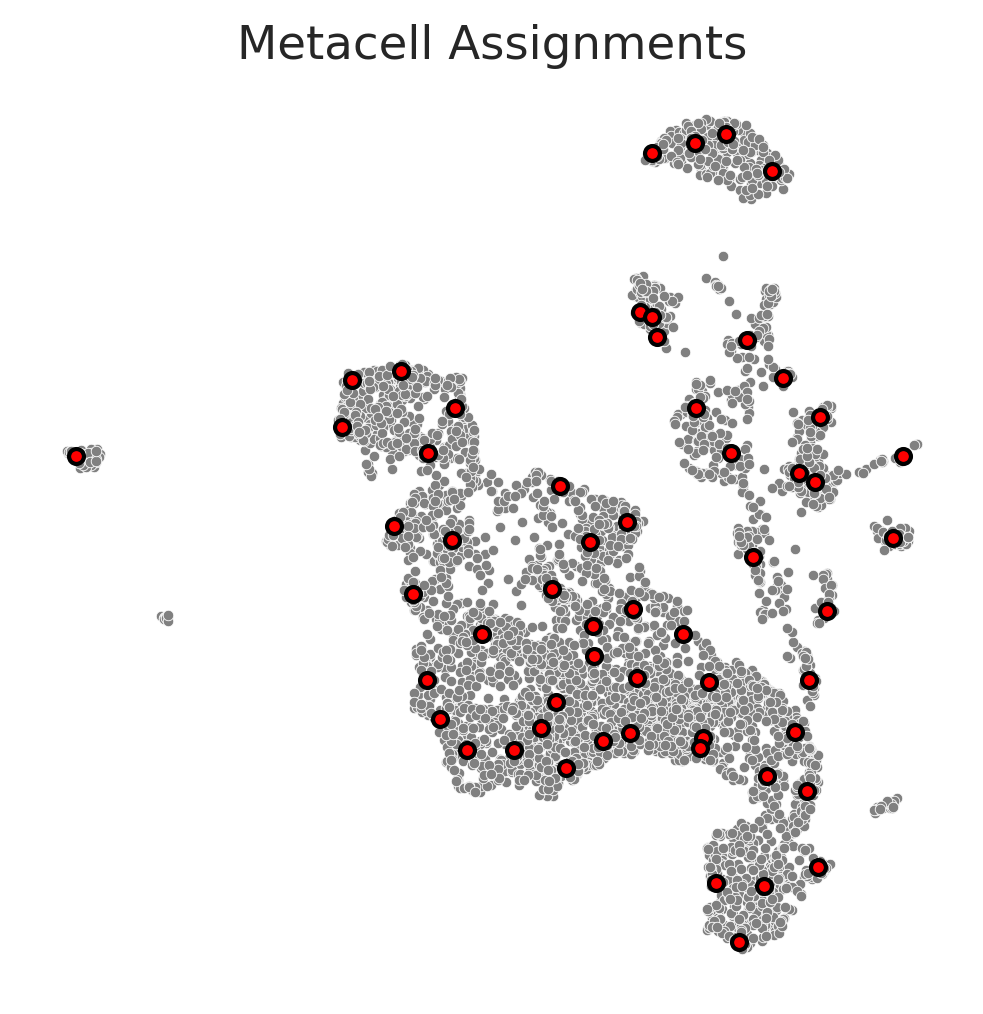

In [15]:
SEACells.plot.plot_2D(rna, key='X_umap', colour_metacells=False)

In [23]:
SEACells.plot.plot_2D(rna, key='X_umap',
        colour_metacells=True)

" SEACells.plot.plot_2D(rna, key='X_umap',\n        colour_metacells=True,\n        figsize = (4,4),\n        SEACell_size = 5,\n        save_as= './plots/rna-seacell-assignments-on-umap.png') "

/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/ak431480/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


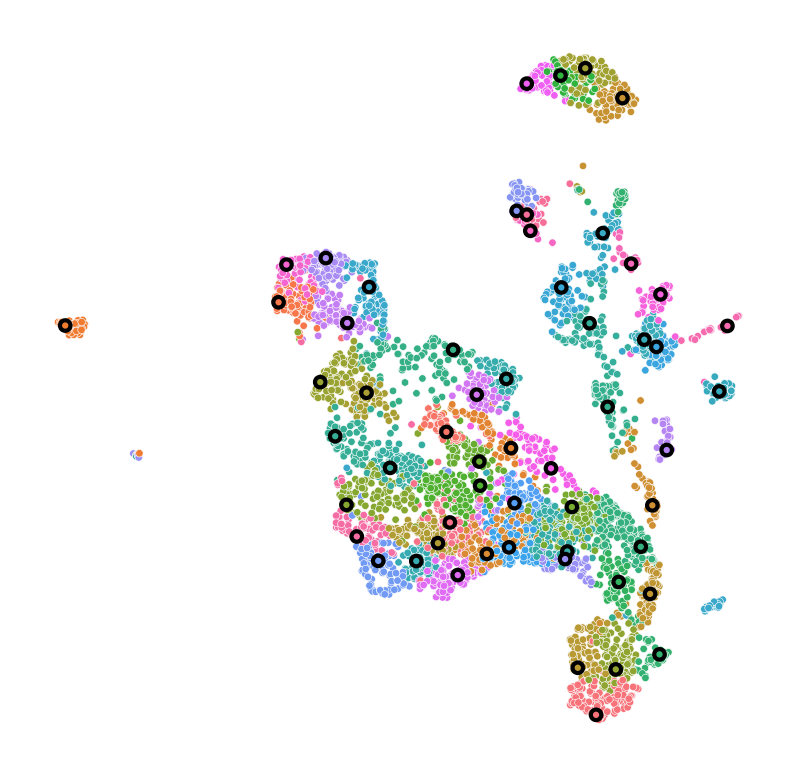

In [28]:
# Save the metacells plot with defined parameters:
# From https://github.com/dpeerlab/SEACells/blob/main/SEACells/plot.py
ad = rna
colour_metacells = True
figsize = (4,4)
SEACell_size = 10
cell_size = 5
key = 'X_umap'
cmap = 'tab10'

umap = pd.DataFrame(ad.obsm[key]).set_index(ad.obs_names).join(ad.obs['SEACell'])
mcs = umap.loc[ad.obs['SEACell'].unique()]

plt.figure(figsize=(figsize))

sns.scatterplot(x=0, y=1,
                hue='SEACell',
                data=umap,
                s=cell_size,
                cmap=cmap,
                legend=None)
sns.scatterplot(x=0, y=1, s=SEACell_size,
                hue='SEACell',
                data=mcs,
                cmap=cmap,
                edgecolor='black', linewidth=1.25,
                legend=None)

plt.xlabel(f'{key}-0')
plt.ylabel(f'{key}-1')
#plt.title('RNA-seq data: metacells on UMAP reduction')
ax = plt.gca()
ax.set_axis_off()

plt.savefig('./plots/rna-seacell-assignments-on-umap.png',dpi=600)

In [ ]:
SEACells.plot.plot_SEACell_sizes(rna, bins=6)

# rna[rna.obs['SEACell'].value_counts()[:10].index].obs['leiden'].value_counts()

In [ ]:
compactness = SEACells.evaluate.compactness(rna, 'X_pca')

plt.figure(figsize=(4,4))
sns.boxplot(data=compactness, y='compactness')
plt.title('Compactness')
sns.despine()
plt.show()
plt.close()

compactness.head()

In [ ]:
rna.obs[rna.obs.index == compactness.sort_values(['compactness'],ascending=False).iloc[0].name]

In [ ]:
separation = SEACells.evaluate.separation(rna, 'X_pca',nth_nbr=1)
plt.figure(figsize=(4,4))
sns.boxplot(data=separation, y='separation')
plt.title('Separation')
sns.despine()
plt.show()
plt.close()

separation.head()

## Run SEACells on ATAC

In [ ]:
## User defined parameters

## Core parameters 
n_SEACells = int(len(atac)/75)
build_kernel_on = 'X_svd' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

model = SEACells.core.SEACells(atac, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

In [ ]:
model.construct_kernel_matrix()
M = model.kernel_matrix

In [ ]:
sns.clustermap(M.toarray()[:500,:500])

In [ ]:
# Initialize archetypes
model.initialize_archetypes()

In [ ]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(atac, model)

In [ ]:
model.fit(min_iter=10, max_iter=50)

In [ ]:
# You can force the model to run additional iterations step-wise using the .step() function
print(f'Ran for {len(model.RSS_iters)} iterations')
for _ in range(5):
    model.step()
print(f'Ran for {len(model.RSS_iters)} iterations')

# Check for convergence 
model.plot_convergence()

In [ ]:
SEACell_atac = SEACells.core.summarize_by_SEACell(atac, SEACells_label='SEACell', summarize_layer='raw')
SEACell_atac

In [ ]:
SEACell_soft_ad = SEACells.core.summarize_by_soft_SEACell(atac, model.A_, celltype_label='leiden',summarize_layer='raw', minimum_weight=0.05)
SEACell_soft_ad

In [ ]:
SEACells.plot.plot_2D(atac, key='X_umap', colour_metacells=False)

In [ ]:
SEACells.plot.plot_2D(atac, key='X_umap', colour_metacells=True)

In [ ]:
# Save the metacells plot with defined parameters:
# From https://github.com/dpeerlab/SEACells/blob/main/SEACells/plot.py
ad = atac
colour_metacells = True
figsize = (4,4)
SEACell_size = 10
cell_size = 5
key = 'X_umap'
cmap = 'tab10'

umap = pd.DataFrame(ad.obsm[key]).set_index(ad.obs_names).join(ad.obs['SEACell'])
mcs = umap.loc[ad.obs['SEACell'].unique()]

plt.figure(figsize=(figsize))

sns.scatterplot(x=0, y=1,
                hue='SEACell',
                data=umap,
                s=cell_size,
                cmap=cmap,
                legend=None)
sns.scatterplot(x=0, y=1, s=SEACell_size,
                hue='SEACell',
                data=mcs,
                cmap=cmap,
                edgecolor='black', linewidth=1.25,
                legend=None)

plt.xlabel(f'{key}-0')
plt.ylabel(f'{key}-1')
#plt.title('ATAC-seq data: metacells on UMAP reduction')
ax = plt.gca()
ax.set_axis_off()

plt.savefig('./plots/atac-seacell-assignments-on-umap.png',dpi=600)

In [ ]:
SEACells.plot.plot_SEACell_sizes(atac, bins=6)

### Saving ATAC & RNA data SEACells

In [ ]:
if all(rna_meta_ad.obs.sort_index().index == atac_meta_ad.obs.sort_index().index):
    rna.write('../data/seacells-rna-multiome10x-mouse.h5ad')
    atac.write('../data/seacells-atac-multiome10x-mouse.h5ad')

In [ ]:
atac_meta_ad, rna_meta_ad = SEACells.genescores.prepare_multiome_anndata(atac, rna, SEACell_label='SEACell')

In [ ]:
if all(rna_meta_ad.obs.sort_index().index == atac_meta_ad.obs.sort_index().index):
    atac_meta_ad.write('../data/seacell-meta-atac-multiome10x-mouse.h5ad')
    rna_meta_ad.write('../data/seacell-meta-rna-multiome10x-mouse.h5ad')
    print('Saved.')

### PEAK-GENE correlation analyses

In [ ]:
rna = sc.read_h5ad('../data/seacells-rna-multiome10x-mouse.h5ad')
rna = rna[:,~rna.var.index.duplicated()]
atac = sc.read_h5ad('../data/seacells-atac-multiome10x-mouse.h5ad')
atac_meta_ad = sc.read_h5ad('../data/seacell-meta-atac-multiome10x-mouse.h5ad')
rna_meta_ad  = sc.read_h5ad('../data/seacell-meta-rna-multiome10x-mouse.h5ad')
rna_meta_ad = rna_meta_ad[:,~rna_meta_ad.var.index.duplicated()]

In [ ]:
#Compute gene peak correlations for all highly variable genes

gene_set =rna[:,rna.var.highly_variable].var_names
gene_peak_cors = SEACells.genescores.get_gene_peak_correlations(atac_meta_ad, rna_meta_ad, 
                                           path_to_gtf='../gencode.vM10.annotation.gtf', 
                                           span=100000, 
                                           n_jobs=1,
                                           gene_set=gene_set)

In [ ]:
def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

gene_peak_corr_df = pd.DataFrame()
for idx in gene_peak_cors.index:
    df = gene_peak_cors[idx]
    
    if isinstance(df, pd.DataFrame):
        df['Gene'] = idx
        gene_peak_corr_df = pd.concat([gene_peak_corr_df,df],axis=0)

gene_peak_corr_df = gene_peak_corr_df.replace(np.nan,1)
gene_peak_corr_df['adj_pval'] = p_adjust_bh(gene_peak_corr_df['pval'])

In [ ]:
gene_peak_corr_df[gene_peak_corr_df['pval']<0.05].sort_values(['pval'])

In [ ]:
gene_peak_corr_df[gene_peak_corr_df['adj_pval']<0.05].sort_values(['adj_pval'])